# Glucose uptake sensitivity

In [1]:
import pandas
import numpy
import matplotlib.pyplot as plt
from Bio import SeqIO
import re
import coralme
plt.rcParams['svg.fonttype'] = 'none'
pandas.set_option('display.max_colwidth', None)
%load_ext autoreload
%autoreload 2


## ME-model

In [2]:
me = coralme.io.pickle.load_pickle_me_model("./pputidame/MEModel-step3-pputida-Keff.pkl")

In [ ]:
medium = pandas.read_csv("./media/M9.txt",index_col="ID",comment="#")["Bound"]
def enforce_medium(model,medium):
    for r in model.reactions.query("^EX_"):
        r.lower_bound = 0
    for r,lb in medium.items():
        model.reactions.get_by_id(r).lower_bound = lb
enforce_medium(me,medium)
assert me.feasibility() == True

In [5]:
me.optimize()

Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	1.4050280687025918	Not feasible
        2	0.7025140343512959	Not feasible
        3	0.3512570171756479	Optimal
        4	0.5268855257634719	Not feasible
        5	0.4390712714695599	Not feasible
        6	0.3951641443226039	Optimal
        7	0.4171177078960819	Optimal
        8	0.4280944896828209	Not feasible
        9	0.4226060987894514	Optimal
       10	0.4253502942361362	Optimal
       11	0.4267223919594786	Not feasible
       12	0.4260363430978074	Not feasible
       13	0.4256933186669718	Optimal
       14	0.4258648308823896	Optimal
       15	0.4259505869900985	Not feasible
       16	0.4259077089362440	Optimal
       17	0.4259291479631713	Optimal
       18	0.4259398674766349	Not feasible
       19	0.4259345077199030	Not feasible
       20	0.4259318278415372	Optimal
       21	0.4259331677807201	Not feasible
       22	0.4259324978111286	Optimal


True

## M-model

In [13]:
import cobra
model = cobra.io.load_json_model("./pputidame/inputs/m_model.json")

Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-03


In [8]:
for r in model.reactions.query("^EX_"):
    r.lower_bound = 0

In [9]:
medium = pandas.read_csv("./media/M9.txt",index_col=0,header=None,comment="#")[1]
for r,b in medium.items():
    model.reactions.get_by_id(r).lower_bound = -b

## Simulations

In [10]:
from tqdm import tqdm

In [11]:
bounds = numpy.arange(1,12,1)
results = {"m":{b:{} for b in bounds},"me":{b:{} for b in bounds}}

In [12]:
for b in tqdm(bounds):
    model.reactions.get_by_id("EX_glc__D_e").lower_bound = -b
    model.reactions.get_by_id("EX_glc__D_e").upper_bound = -b
    results["m"][b] = model.optimize().to_frame()["fluxes"]

100%|██████████| 11/11 [00:00<00:00, 35.10it/s]


In [13]:
for b in tqdm(bounds):
    me.reactions.get_by_id("EX_glc__D_e").lower_bound = -b
    me.reactions.get_by_id("EX_glc__D_e").upper_bound = -b
    me.optimize(max_mu=1.0)
    results["me"][b] = me.solution.to_frame()["fluxes"]

  0%|          | 0/11 [00:00<?, ?it/s]

Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	0.5000000000000000	Not feasible
        2	0.2500000000000000	Not feasible
        3	0.1250000000000000	Not feasible
        4	0.0625000000000000	Optimal
        5	0.0937500000000000	Not feasible
        6	0.0781250000000000	Optimal
        7	0.0859375000000000	Not feasible
        8	0.0820312500000000	Not feasible
        9	0.0800781250000000	Optimal
       10	0.0810546875000000	Optimal
       11	0.0815429687500000	Optimal
       12	0.0817871093750000	Not feasible
       13	0.0816650390625000	Optimal
       14	0.0817260742187500	Not feasible
       15	0.0816955566406250	Optimal
       16	0.0817108154296875	Optimal
       17	0.0817184448242188	Not feasible
       18	0.0817146301269531	Optimal
       19	0.0817165374755859	Not feasible


  9%|▉         | 1/11 [08:09<1:21:34, 489.40s/it]

       20	0.0817155838012695	Not feasible
Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	0.5000000000000000	Not feasible
        2	0.2500000000000000	Not feasible
        3	0.1250000000000000	Optimal
        4	0.1875000000000000	Not feasible
        5	0.1562500000000000	Optimal
        6	0.1718750000000000	Not feasible
        7	0.1640625000000000	Optimal
        8	0.1679687500000000	Not feasible
        9	0.1660156250000000	Optimal
       10	0.1669921875000000	Optimal
       11	0.1674804687500000	Optimal
       12	0.1677246093750000	Not feasible
       13	0.1676025390625000	Optimal
       14	0.1676635742187500	Optimal
       15	0.1676940917968750	Not feasible
       16	0.1676788330078125	Not feasible
       17	0.1676712036132812	Optimal
       18	0.1676750183105469	Optimal
       19	0.1676769256591797	Not feasible


 18%|█▊        | 2/11 [14:46<1:05:13, 434.83s/it]

       20	0.1676759719848633	Optimal
Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	0.5000000000000000	Not feasible
        2	0.2500000000000000	Optimal
        3	0.3750000000000000	Not feasible
        4	0.3125000000000000	Not feasible
        5	0.2812500000000000	Not feasible
        6	0.2656250000000000	Not feasible
        7	0.2578125000000000	Not feasible
        8	0.2539062500000000	Not feasible
        9	0.2519531250000000	Optimal
       10	0.2529296875000000	Optimal
       11	0.2534179687500000	Optimal
       12	0.2536621093750000	Optimal
       13	0.2537841796875000	Optimal
       14	0.2538452148437500	Not feasible
       15	0.2538146972656250	Optimal
       16	0.2538299560546875	Optimal
       17	0.2538375854492188	Optimal
       18	0.2538414001464844	Optimal
       19	0.2538433074951172	Not feasible


 27%|██▋       | 3/11 [19:35<49:06, 368.30s/it]  

       20	0.2538423538208008	Optimal
Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	0.5000000000000000	Not feasible
        2	0.2500000000000000	Optimal
        3	0.3750000000000000	Not feasible
        4	0.3125000000000000	Optimal
        5	0.3437500000000000	Not feasible
        6	0.3281250000000000	Optimal
        7	0.3359375000000000	Optimal
        8	0.3398437500000000	Optimal
        9	0.3417968750000000	Not feasible
       10	0.3408203125000000	Not feasible
       11	0.3403320312500000	Not feasible
       12	0.3400878906250000	Not feasible
       13	0.3399658203125000	Optimal
       14	0.3400268554687500	Not feasible
       15	0.3399963378906250	Not feasible
       16	0.3399810791015625	Not feasible
       17	0.3399734497070312	Optimal
       18	0.3399772644042969	Optimal
       19	0.3399791717529297	Optimal


 36%|███▋      | 4/11 [24:54<40:43, 349.05s/it]

       20	0.3399801254272461	Optimal
Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	0.5000000000000000	Not feasible
        2	0.2500000000000000	Optimal
        3	0.3750000000000000	Optimal
        4	0.4375000000000000	Not feasible
        5	0.4062500000000000	Optimal
        6	0.4218750000000000	Optimal
        7	0.4296875000000000	Not feasible
        8	0.4257812500000000	Optimal
        9	0.4277343750000000	Not feasible
       10	0.4267578125000000	Not feasible
       11	0.4262695312500000	Not feasible
       12	0.4260253906250000	Not feasible
       13	0.4259033203125000	Optimal
       14	0.4259643554687500	Not feasible
       15	0.4259338378906250	Not feasible
       16	0.4259185791015625	Optimal
       17	0.4259262084960938	Optimal
       18	0.4259300231933594	Optimal
       19	0.4259319305419922	Optimal


 45%|████▌     | 5/11 [30:05<33:30, 335.16s/it]

       20	0.4259328842163086	Optimal
Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	0.5000000000000000	Optimal
        2	0.7500000000000000	Not feasible
        3	0.6250000000000000	Not feasible
        4	0.5625000000000000	Not feasible
        5	0.5312500000000000	Not feasible
        6	0.5156250000000000	Not feasible
        7	0.5078125000000000	Optimal
        8	0.5117187500000000	Not feasible
        9	0.5097656250000000	Optimal
       10	0.5107421875000000	Optimal
       11	0.5112304687500000	Not feasible
       12	0.5109863281250000	Optimal
       13	0.5111083984375000	Not feasible
       14	0.5110473632812500	Not feasible
       15	0.5110168457031250	Optimal
       16	0.5110321044921875	Optimal
       17	0.5110397338867188	Optimal
       18	0.5110435485839844	Optimal
       19	0.5110454559326172	Optimal


 55%|█████▍    | 6/11 [33:20<23:57, 287.45s/it]

       20	0.5110464096069336	Optimal
Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	0.5000000000000000	Optimal
        2	0.7500000000000000	Not feasible
        3	0.6250000000000000	Not feasible
        4	0.5625000000000000	Not feasible
        5	0.5312500000000000	Optimal
        6	0.5468750000000000	Optimal
        7	0.5546875000000000	Not feasible
        8	0.5507812500000000	Not feasible
        9	0.5488281250000000	Optimal
       10	0.5498046875000000	Not feasible
       11	0.5493164062500000	Optimal
       12	0.5495605468750000	Optimal
       13	0.5496826171875000	Not feasible
       14	0.5496215820312500	Not feasible
       15	0.5495910644531250	Not feasible
       16	0.5495758056640625	Not feasible
       17	0.5495681762695312	Not feasible
       18	0.5495643615722656	Optimal
       19	0.5495662689208984	Not feasible


 64%|██████▎   | 7/11 [36:34<17:08, 257.02s/it]

       20	0.5495653152465820	Not feasible
Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	0.5000000000000000	Optimal
        2	0.7500000000000000	Not feasible
        3	0.6250000000000000	Not feasible
        4	0.5625000000000000	Optimal
        5	0.5937500000000000	Not feasible
        6	0.5781250000000000	Not feasible
        7	0.5703125000000000	Optimal
        8	0.5742187500000000	Optimal
        9	0.5761718750000000	Optimal
       10	0.5771484375000000	Not feasible
       11	0.5766601562500000	Not feasible
       12	0.5764160156250000	Optimal
       13	0.5765380859375000	Optimal
       14	0.5765991210937500	Optimal
       15	0.5766296386718750	Not feasible
       16	0.5766143798828125	Optimal
       17	0.5766220092773438	Not feasible
       18	0.5766181945800781	Optimal
       19	0.5766201019287109	Not feasible


 73%|███████▎  | 8/11 [39:41<11:44, 234.84s/it]

       20	0.5766191482543945	Optimal
Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	0.5000000000000000	Optimal
        2	0.7500000000000000	Not feasible
        3	0.6250000000000000	Not feasible
        4	0.5625000000000000	Optimal
        5	0.5937500000000000	Not feasible
        6	0.5781250000000000	Not feasible
        7	0.5703125000000000	Optimal
        8	0.5742187500000000	Optimal
        9	0.5761718750000000	Optimal
       10	0.5771484375000000	Not feasible
       11	0.5766601562500000	Not feasible
       12	0.5764160156250000	Optimal
       13	0.5765380859375000	Not feasible
       14	0.5764770507812500	Optimal
       15	0.5765075683593750	Not feasible
       16	0.5764923095703125	Not feasible
       17	0.5764846801757812	Not feasible
       18	0.5764808654785156	Optimal
       19	0.5764827728271484	Optimal


 82%|████████▏ | 9/11 [42:56<07:24, 222.30s/it]

       20	0.5764837265014648	Optimal
Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	0.5000000000000000	Optimal
        2	0.7500000000000000	Not feasible
        3	0.6250000000000000	Not feasible
        4	0.5625000000000000	Optimal
        5	0.5937500000000000	Not feasible
        6	0.5781250000000000	Not feasible
        7	0.5703125000000000	Optimal
        8	0.5742187500000000	Optimal
        9	0.5761718750000000	Optimal
       10	0.5771484375000000	Not feasible
       11	0.5766601562500000	Not feasible
       12	0.5764160156250000	Not feasible
       13	0.5762939453125000	Not feasible
       14	0.5762329101562500	Optimal
       15	0.5762634277343750	Optimal
       16	0.5762786865234375	Optimal
       17	0.5762863159179688	Optimal
       18	0.5762901306152344	Optimal
       19	0.5762920379638672	Not feasible


 91%|█████████ | 10/11 [46:07<03:32, 212.59s/it]

       20	0.5762910842895508	Optimal
Iteration	 Solution to check	Solver Status
---------	------------------	-------------
        1	0.5000000000000000	Optimal
        2	0.7500000000000000	Not feasible
        3	0.6250000000000000	Not feasible
        4	0.5625000000000000	Optimal
        5	0.5937500000000000	Not feasible
        6	0.5781250000000000	Not feasible
        7	0.5703125000000000	Optimal
        8	0.5742187500000000	Optimal
        9	0.5761718750000000	Not feasible
       10	0.5751953125000000	Optimal
       11	0.5756835937500000	Optimal
       12	0.5759277343750000	Optimal
       13	0.5760498046875000	Optimal
       14	0.5761108398437500	Not feasible
       15	0.5760803222656250	Optimal
       16	0.5760955810546875	Optimal
       17	0.5761032104492188	Not feasible
       18	0.5760993957519531	Not feasible
       19	0.5760974884033203	Optimal


100%|██████████| 11/11 [49:14<00:00, 268.62s/it]

       20	0.5760984420776367	Optimal


In [14]:
for i,df in results.items():
    results[i] = pandas.DataFrame.from_dict(results[i])

In [ ]:
results["m"].to_csv("./datasets/carbon-source-uptake/m-fluxes.csv")
results["me"].to_csv("./datasets/carbon-source-uptake/me-fluxes.csv")

### Compare with experimental results

In [8]:
results = {}
results["m"] = pandas.read_csv("./datasets/carbon-source-uptake/m-fluxes.csv",index_col=0)
results["me"] = pandas.read_csv("./datasets/carbon-source-uptake/me-fluxes.csv",index_col=0)

In [3]:
experimental = pandas.read_csv("./datasets/carbon-source-uptake/references.csv",index_col=0,comment="#")
experimental["In vivo"] = experimental["In vivo"].apply(lambda x:x.split("/")[0]).astype(float)
experimental = experimental.drop("Gluconate")

In [4]:
experimental

,uptake,gluconate,2-ketogluconate,iJN746,iEB1050,PpuQY1140,iJN1462,In vivo,Reference
Source,,,,,,,,,
Glucose,6.30,NaN,NaN,0.76/NA,0.91/NA,0.50/NA,0.61/NA,0.56,del Castillo et al. (2007)
Glucose,10.90,2.8,2.6,0.70/NA,0.81/NA,0.49/NA,0.57/NA,0.57,Blank et al. (2008)
Glucose,9.16,NaN,NaN,NA/NA,NA/NA,NA/NA,NA/NA,0.61,Wang et al. (2019)
Glucose,6.14,NaN,NaN,NA/NA,NA/NA,NA/NA,NA/NA,0.55,Nikel et al. (2015)
Glucose,8.26,NaN,NaN,NA/NA,NA/NA,NA/NA,NA/NA,0.59,van Duuren et al. (2013)


In [5]:
experimental["In vivo"].mean(),experimental["In vivo"].std()

(0.576, 0.024083189157584565)

In [6]:
experimental["uptake"].mean(),experimental["uptake"].std()

(8.152, 2.0035768016225384)

In [21]:
results["me"].to_csv("./datasets/predictions/KT2440-UPF36-M9-CarbonSourceUptakes.csv")

### Secretion

In [10]:
carbon_exchanges = [i.id for i in me.reactions.query("^EX_") if me.metabolites.has_id(i.id.split("EX_")[-1]) and me.metabolites.get_by_id(i.id.split("EX_")[-1]).elements.get("C",0)]

In [11]:
tmp = results["me"].loc[carbon_exchanges].drop("EX_co2_e")
simulated_exchanges = tmp[(tmp.index.str.contains("EX_") & (tmp.any(axis=1)))].sort_values("11")
simulated_secretions = simulated_exchanges[(simulated_exchanges>0.01).any(axis=1)]
simulated_secretions

,1,2,3,4,5,6,7,8,9,10,11
EX_ac_e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.356129,0.355949,0.355771,0.355592
EX_2dhglcn_e,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,1.175657,2.360175,3.544693


#### Both

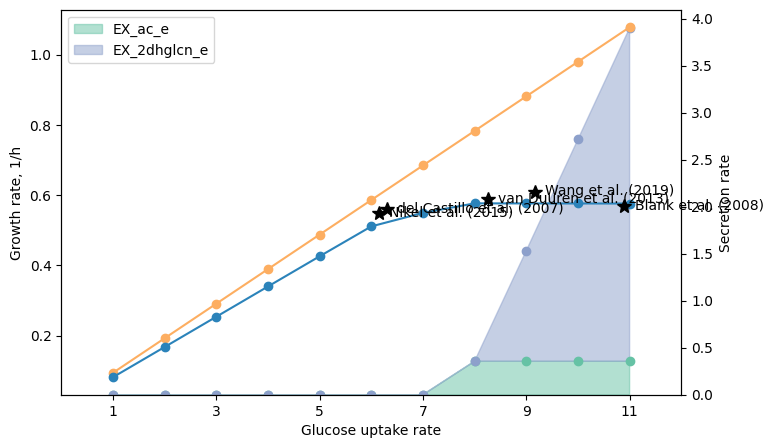

In [93]:
fig,ax1 = plt.subplots(1,1,figsize=(7,5))
results["m"].loc["BIOMASS_KT2440_WT3"].plot(marker="o",ax=ax1,label="m",color="#fdae61")
results["me"].loc["biomass_dilution"].plot(marker="o",ax=ax1,label="me",color="#2b83ba")
ax1.set_ylabel("Growth rate, 1/h")
ax1.set_xlabel("Glucose uptake rate")
# Experimental
for i,row in experimental.iterrows():
    ax1.plot(row["uptake"]-1,row["In vivo"],"*",color="black",markersize=10)
    ax1.text(row["uptake"]-0.8,row["In vivo"]-0.01,row["Reference"])
ax1.set_xlim([-1,11])

# Create second axis sharing the same x-axis
ax2 = ax1.twinx()
# ax2.set_ylim([0,6])
df = simulated_secretions.T
# Colors
colors = ["#66c2a5","#8da0cb"]
# Create the stacked area plot
df.plot.area(alpha=0.5, figsize=(8, 5),color=colors,linestyle="",ax=ax2)
# Compute cumulative sums along the columns (i.e. stacking order)
df_cumsum = df.cumsum(axis=1)
# Overlay markers at the cumulative stacking heights
for i, col in enumerate(df.columns):
    ax2.plot(df.index, df_cumsum[col], marker='o', linestyle='', color=colors[i], label='_nolegend_')
ax2.set_ylabel("Secretion rate")
ax2.set_zorder(0)  # Move ax2 behind
ax1.set_zorder(1)  # Move ax1 in front
ax1.patch.set_visible(False)  # Hide ax1 background
plt.savefig("./figures/Secretion-MvsME.svg",format="SVG")

### In the M-model

In [96]:
tmp = results["m"].loc[[i for i in carbon_exchanges if i in results["m"].index]]
simulated_exchanges = tmp[(tmp.index.str.contains("EX_") & (tmp.any(axis=1)))].sort_values("11")
simulated_secretions = simulated_exchanges[(simulated_exchanges>0.01).any(axis=1)]
simulated_secretions

,1,2,3,4,5,6,7,8,9,10,11
EX_co2_e,2.205752,4.243924,6.282096,8.320268,10.358439,12.396611,14.434783,16.472954,18.511126,20.549298,22.587469
